## 简介
Fer2013数据集，用于人脸表情识别

包含35887个样本，其中80%是训练数据集，10%是验证数据集，10%是测试数据集

## 目标
(i) 将卷积神经网络（CNN）应用于人脸表情识别
 
(ii) 将每个面部图像正确分类为七种面部情绪类别之一 **anger(生气)**, **disgust(厌恶)**, **fear(害怕)**, **happiness(高兴)**, **sadness(伤心)**, **surprise(惊讶)**, and **中立**.


---------------------------------------------------------------------------------------
## 导入需要的库

In [1]:
import numpy as np  # 线性代数
import pandas as pd  # 数据预处理, CSV 文件 I/O (e.g. pd.read_csv)

from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("./dataset"))

['fer2013.csv']


## 数据集概览

In [3]:
data = pd.read_csv('./dataset/fer2013.csv')
# 查看数据集形状
data.shape

(35887, 3)

In [4]:
#预览前10行数据
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [5]:
#查看数据集的分类情况
#80% 训练, 10% 验证 and 10% 测试
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
#查看表情分类数据
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts().sort_index().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Disgust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


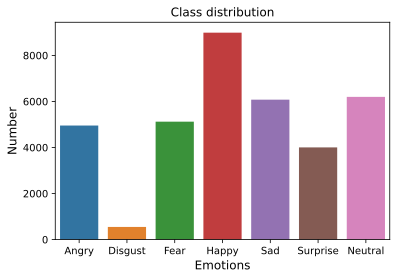

In [7]:
# 绘制类别分布条形图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6, 4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

### 图片样本示例

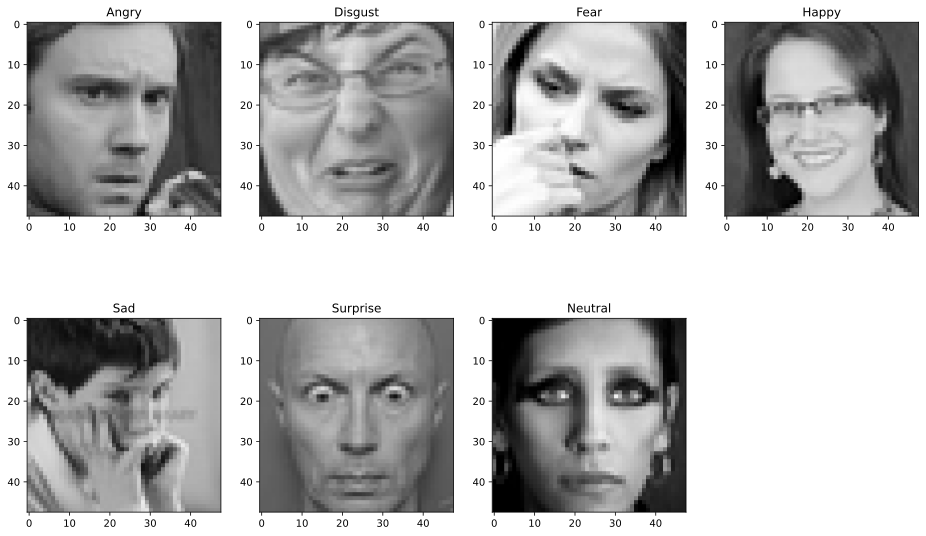

In [8]:
def row2image_label(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48, 48)
    image = np.zeros((48, 48, 3))
    image[:, :, 0] = img
    image[:, :, 1] = img
    image[:, :, 2] = img
    return image.astype(np.uint8), emotion

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(0, figsize=(16, 10))
for i in range(1, 8):
    face = data[data['emotion'] == i - 1].iloc[0]
    img, label = row2image_label(face)
    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.title(label)

plt.show()

----------------------------------------------------------------------------------
## 数据预处理
1. 分割数据为3个部分: train, validation, test
2. 将数据标签由字符串改为整数
3. 调整图片大小为 48x48, 归一化图像
4. 更改标签编码为one-hot, e.g. 类别3(Happy)为 **[0,0,0,1,0,0,0]**

In [9]:
#分割数据为: train, validation, test
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
print(f"train shape: {data_train.shape}")
print(f"validation shape: {data_val.shape}")
print(f"test shape: {data_test.shape}")

train shape: (28709, 3)
validation shape: (3589, 3)
test shape: (3589, 3)


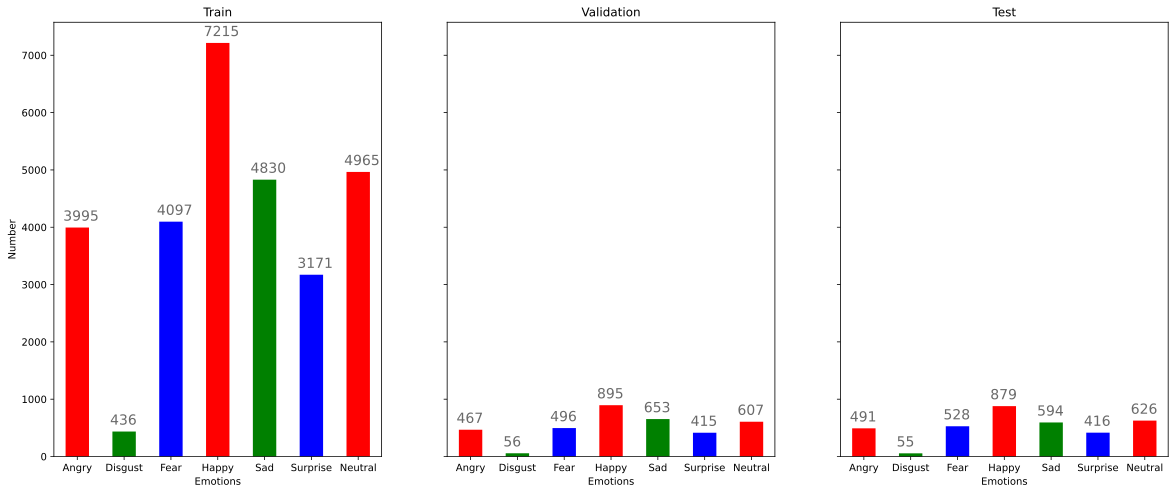

In [10]:
# 绘制train, val, test的条形图
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


def setup_axe(axe, df, title):
    df['emotion'].value_counts().sort_index().plot(ax=axe, kind='bar', rot=0,
                                                   color=['r', 'g', 'b', 'r', 'g', 'b', 'r'])
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)

    # 使用上述列表设置单个条形标签
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x() - .05, i.get_height() + 120,
                 str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                 rotation=0)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey='all')
setup_axe(axes[0], data_train, 'Train')
setup_axe(axes[1], data_val, 'Validation')
setup_axe(axes[2], data_test, 'Test')
plt.show()

后面两幅图与第一幅图共享y轴

**train**, **validation**, **test** 数据集的占比分别为 **80%**, **10%** 和 **10%**

这些数据集的每一类的确切数量都写在其x轴栏的顶部。

In [11]:
#初始化参数
num_classes = 7
width, height = 48, 48
num_epochs = 300
batch_size = 128
num_features = 64
rate_drop = 0.1

In [12]:
# CRNO -- Convert, Reshape, Normalize, One-hot encoding
# (i) 将数据标签由字符串改为整数
# (ii) 调整图片大小为 48x48, 归一化图像
# (iii) 更改标签编码为one-hot, e.g. 类别3(Happy)为 **[0,0,0,1,0,0,0]**

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1, width, height, 1) / 255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y


train_X, train_Y = CRNO(data_train, "train")  #training data
val_X, val_Y = CRNO(data_val, "val")  #validation data
test_X, test_Y = CRNO(data_test, "test")  #test data

train _X shape: (28709, 48, 48, 1),  train _Y shape: (28709, 7)
val _X shape: (3589, 48, 48, 1),  val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1),  test _Y shape: (3589, 7)
<class 'numpy.ndarray'>


----------------------------------------------------------------------------------
## 构建我们的CNN

### CNN 结构:
Conv Sages 1 --> Conv Stages 2 --> Conv Stages 3 --> Conv Stages 4 --> Flatten --> Full Connection --> Softmax Output Layer

### Conv Stages
Conv Block --> Max Pooling

### Conv Block
Conv --> BN --> ReLU

In [12]:
model = Sequential()

# ---------- Convolutional Stages 1 ----------
# ***** Conv Block a *****
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(width, height, 1),
                 data_format='channels_last', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---------- Convolutional Stages 2 ----------
# ***** Conv Block a *****
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---------- Convolutional Stages 3 ----------
# ***** Conv Block a *****
model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---------- Convolutional Stages 4 ----------
# ***** Conv Block a *****
model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Full connection
model.add(Dense(4096, activation='relu', kernel_regularizer=l2()))
model.add(Dropout(rate_drop))
model.add(Dense(4096, activation='relu', kernel_regularizer=l2()))
model.add(Dropout(rate_drop))

#output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2()))

model.compile(loss=['categorical_crossentropy'],
              optimizer=SGD(momentum=0.9, nesterov=True ,decay=1e-4),
              metrics=['accuracy'])

model.summary()

2021-12-26 06:57:01.421534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 06:57:01.510641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 06:57:01.511328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 06:57:01.512438: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0

In [13]:
# 数据增强
data_generator = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=10,
    featurewise_std_normalization=False,
    horizontal_flip=True)

es = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75, patience=5, verbose=1)

history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                    # steps_per_epoch=len(train_X) / batch_size,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    callbacks=[es, reduce_lr],
                    validation_data=(val_X, val_Y))

2021-12-26 06:57:04.044888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2021-12-26 06:57:06.199139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


225/225 - 21s - loss: 59.5292 - accuracy: 0.2511 - val_loss: 37.2559 - val_accuracy: 0.2494
Epoch 2/300
225/225 - 12s - loss: 25.2895 - accuracy: 0.2730 - val_loss: 16.4497 - val_accuracy: 0.2494
Epoch 3/300
225/225 - 12s - loss: 11.4968 - accuracy: 0.3016 - val_loss: 7.8310 - val_accuracy: 0.3199
Epoch 4/300
225/225 - 13s - loss: 5.7623 - accuracy: 0.3647 - val_loss: 4.6345 - val_accuracy: 0.2725
Epoch 5/300
225/225 - 13s - loss: 3.2932 - accuracy: 0.4214 - val_loss: 2.7740 - val_accuracy: 0.3539
Epoch 6/300
225/225 - 13s - loss: 2.2110 - accuracy: 0.4627 - val_loss: 1.9444 - val_accuracy: 0.4575
Epoch 7/300
225/225 - 13s - loss: 1.7118 - accuracy: 0.4895 - val_loss: 1.6599 - val_accuracy: 0.4659
Epoch 8/300
225/225 - 12s - loss: 1.4668 - accuracy: 0.5097 - val_loss: 1.5355 - val_accuracy: 0.4765
Epoch 9/300
225/225 - 13s - loss: 1.3493 - accuracy: 0.5239 - val_loss: 1.4145 - val_accuracy: 0.4854
Epoch 10/300
225/225 - 12s - loss: 1.2755 - accuracy: 0.5401 - val_loss: 1.3835 - val_acc

## 可视化训练效果

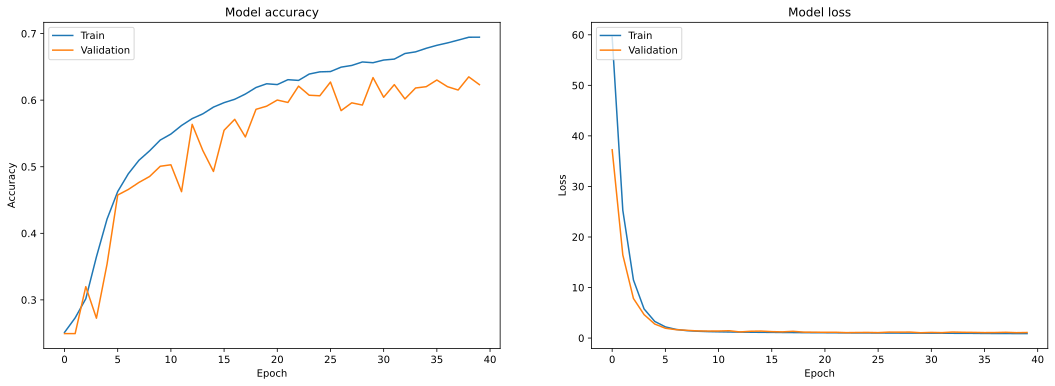

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# 绘制训练和验证精度曲线
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# 绘制训练和验证损失曲线
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 评估测试效果

In [15]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6528


## 使用混淆矩阵进行更多的分析

绘制混淆矩阵，以找出哪种情绪通常会相互混淆。

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    此函数打印和绘制混淆矩阵
    可以通过设置“normalize=True”来应用规范化。
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    # 仅使用数据中显示的标签
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # 显示所有的标记...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... 用相应的列表条目标记它们
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # 旋转x轴标签并设置其对齐方式。
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # 在数据维度上循环并创建文本批注
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

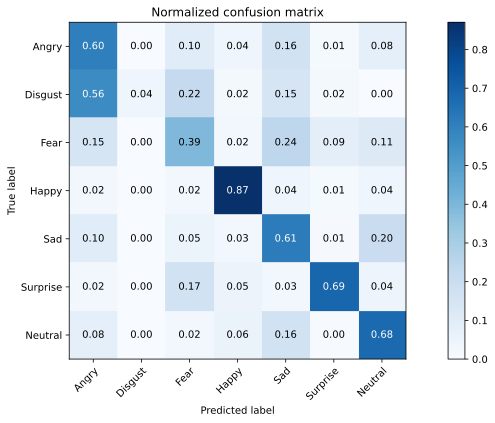

In [17]:
# 绘制归一化混淆矩阵
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

## 保存我们的模型

In [18]:
model.save('FER_Model.h5')